In [12]:
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

 # 计算视差图

预处理

In [13]:
def preprocess(img1, img2):
    # 彩色图->灰度图
    if (img1.ndim == 3):
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)  # 通过OpenCV加载的图像通道顺序是BGR
    if (img2.ndim == 3):
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # 直方图均衡 减轻光照不均的影响
    img1 = cv2.equalizeHist(img1)
    img2 = cv2.equalizeHist(img2)

    # 高斯滤波 在图片质量不好时使用
    # kernel_size = (3, 3)  # 内核大小
    # img1 = cv2.GaussianBlur(img1, kernel_size,0)
    # img2 = cv2.GaussianBlur(img2, kernel_size,0)

    # 中值滤波 消除孤立的噪点
    img1 = cv2.medianBlur(img1, 3)
    img2 = cv2.medianBlur(img2, 3)
    return img1, img2


视差计算

In [14]:
def stereoMatchSGBM(left_image, right_image, down_scale=False):
    # SGBM匹配参数设置
    if left_image.ndim == 2:
        img_channels = 1
    else:
        img_channels = 3
    blockSize = 5
    paraml = {'minDisparity': 0,
             'numDisparities': 320,#SGBM认为图像左侧前numDisparities列是不能估计视差的，所以会看到视差图左侧有一块是黑色
             'blockSize': blockSize,
             'P1': 64 * img_channels * blockSize ** 2,
             'P2': 256 * img_channels * blockSize ** 2,# 加大P1、P2，进行弱纹理优化
             'disp12MaxDiff': 1,
             'preFilterCap': 63,
             'uniquenessRatio': 15,
             'speckleWindowSize': 100,
             'speckleRange': 1,
             'mode': cv2.STEREO_SGBM_MODE_SGBM_3WAY
             }
 
    # 构建SGBM对象
    left_matcher = cv2.StereoSGBM_create(**paraml)
    paramr = paraml
    paramr['minDisparity'] = -paraml['numDisparities']
    right_matcher = cv2.StereoSGBM_create(**paramr)
 
    # 计算视差图
    size = (left_image.shape[1], left_image.shape[0])
    if down_scale == False:
        disparity_left = left_matcher.compute(left_image, right_image)
        disparity_right = right_matcher.compute(right_image, left_image)
 
    else:# 降采样并插值处理图像，提高计算效率，并使图像更加平滑，减少图像噪声
        left_image_down = cv2.pyrDown(left_image)
        right_image_down = cv2.pyrDown(right_image)
        factor = left_image.shape[1] / left_image_down.shape[1]
 
        disparity_left_half = left_matcher.compute(left_image_down, right_image_down)
        disparity_right_half = right_matcher.compute(right_image_down, left_image_down)
        disparity_left = cv2.resize(disparity_left_half, size, interpolation=cv2.INTER_AREA)
        disparity_right = cv2.resize(disparity_right_half, size, interpolation=cv2.INTER_AREA)
        disparity_left = factor * disparity_left
        disparity_right = factor * disparity_right
 
    # 真实视差（因为SGBM算法得到的视差是×16的）
    trueDisp_left = disparity_left.astype(np.float32) / 16.
    trueDisp_right = disparity_right.astype(np.float32) / 16.
 
    return trueDisp_left, trueDisp_right

显示图片

In [15]:
def show(name1,image1,name2,image2,save_name):

    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    
    # 水平拼接两张图像
    concatenated_image = np.hstack((image1, image2))

    # 显示拼接后的图像
    plt.imshow(concatenated_image)
    plt.axis('off')
    
    cv2.imwrite('img/'+ save_name + '.jpg', concatenated_image)

    # 对第一张图像添加标注
    plt.text(image1.shape[1] // 2, -20, name1, color='black', fontsize=12, ha='center')

    # 对第二张图像添加标注
    plt.text(image1.shape[1] + image2.shape[1] // 2, -20, name2, color='black', fontsize=12, ha='center')
    
    plt.show()

主函数

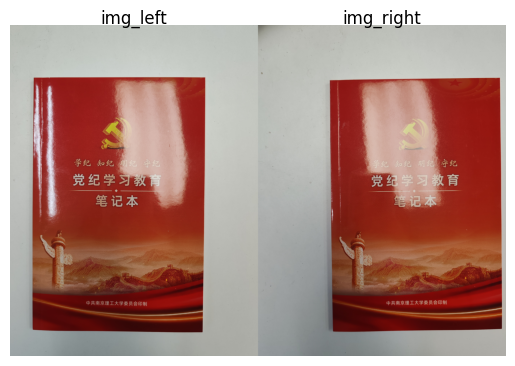

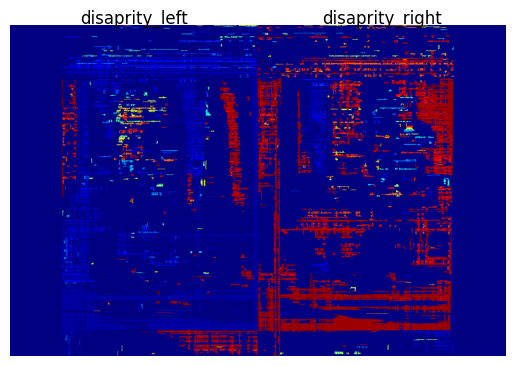

In [24]:
if __name__ == '__main__':


    iml = cv2.imread("img/IMG_l.jpg", 1)  #左图
    imr = cv2.imread("img/IMG_r.jpg", 1)  # 右图
    if (iml is None) or (imr is None):
        print("Error: Images are empty, please check your image's path!")
        sys.exit(0)

    height, width = iml.shape[0:2]

    show('img_left',iml,'img_right',imr,'concatenated_img')
    
    # 立体匹配
    iml, imr = preprocess(iml, imr)  # 预处理
    disp1,disp2 = stereoMatchSGBM(iml, imr, True)
    
    #创建滤波器
    wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher0)
    wls_filter.setLambda(80000)
    wls_filter.setSigmaColor(1.3)
    
    #滤波器平滑视差图
    disp1 = wls_filter.filter(disp1, iml, None, disp2).astype(np.float32)/16
    disp2 = wls_filter.filter(disp2, im2, None, disp1).astype(np.float32)/16
    
   # 归一化处理，使得像素值的范围在[0, 255]之间
    disp1 = cv2.normalize(disp1,None,alpha=0,beta=255,norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_8U)
    disp2 = cv2.normalize(disp2,None,alpha=0,beta=255,norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_8U)
    
    #将灰度图像转换为伪彩色图像，以增强可视化效果
    disp1 = cv2.applyColorMap(disp1*8,2)
    disp2 = cv2.applyColorMap(disp2*8,2)
    
    show('disaprity_left',disp1,'disaprity_right',disp2,'concatenated_disaprity')
